In [2]:
import pandas as pd
import os
import numpy as np
import json
import sys
from tqdm import tqdm
from geopy.distance import geodesic 
import seaborn as sns
import matplotlib.pyplot as plt

# system setup
user_info_filename = "user_fix.csv"
trace_info_filename = "traces_fix.csv"

# node config filename
topology_filename = "topology.json"

## 1 Preprocess User info data

#### 1.1 load user
load user and filter out users with no country info

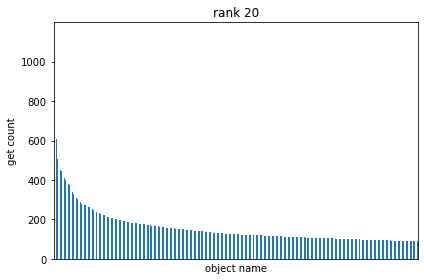

In [15]:
# load user info

user_df = pd.read_csv(user_info_filename)
trace_df = pd.read_csv(trace_info_filename)
#print(user_df.columns)
#print(trace_df.columns)

# calculate the timestamp offset
start_timestamp = trace_df.loc[0, "timestamp"]

def timestamp_offset(ts):
    return ts - start_timestamp

trace_df["timestamp_offset"] = trace_df["timestamp"].apply(timestamp_offset)

user_df = pd.merge(user_df, trace_df, on='user_id', how='inner')
#print(user_df)
#print(trace_df)

value_counts = trace_df['file_url'].value_counts().head(1000)
value_counts = value_counts[1:]

value_counts.plot(kind='bar')
plt.title("rank 20")
plt.xlabel("object name")
plt.ylabel("get count")
plt.xticks([])

plt.tight_layout()
plt.show()

#### 1.2 split user to different node

In [ ]:
topology_json = ""
with open(topology_filename) as json_file:
    topology_json = json.load(json_file)

access_nodes = topology_json["topology"]["layer-2"]
print(access_nodes)


#### 1.3 allocate user to node

In [ ]:
import math

def euclidean_distance(lat1, lon1, lat2, lon2):
    x = lat2 - lat1
    y = lon2 - lon1
    distance = math.sqrt(x**2 + y**2)

    return distance

def calculate_distance(row, nodes, prog_bar):
    min_distance = 1000000000000000000
    min_idx = -1
    for idx, node in enumerate(nodes):
        user_coords = (row['lat'], row['lng'])
        node_coords = node["location"]
        distance = euclidean_distance(user_coords[0], -user_coords[1], node_coords[0], node_coords[1])
        if min_idx == -1 :
            min_idx = idx
            min_distance = distance
        elif distance < min_distance:
            min_distance = distance
            min_idx = idx

    nodes[min_idx]["users_id"].append(row["user_id"])
    prog_bar.update(1)

progress_bar = tqdm(user_df.iterrows(), total=len(user_df))

for node in access_nodes: 
    node["users_id"] = []

user_df['distances'] = user_df.apply(calculate_distance, axis=1, nodes=access_nodes, prog_bar=progress_bar)

In [ ]:
for node in access_nodes:
    print(len(node["users_id"]))

## 2 Extract node trace

#### 2.1 allocate trace to node

In [ ]:
trace_split_result = {}

for node in access_nodes:
    node_name = node["name"]
    users_id = node["users_id"]
    
    mask = trace_df["user_id"].isin(users_id)
    
    filtered_trace_df = trace_df[mask].reset_index(drop=True)
    
    # save result
    trace_split_result[node_name] = filtered_trace_df

for name, trace in trace_split_result.items():
    print(name)
    print(trace)

#### 2.2 split to each node

In [ ]:
# doing aisa node
# maximum trace line 10000
# maximum container number 10
max_line = 10000
max_container = 20

for node_name, node_traces in trace_split_result.items():
    # asia-node
    traces_size = len(node_traces)
    print(node_name, " with trace size ", traces_size)
    container_num = traces_size // max_line
    if container_num <= 0:
        container_num = 1
    elif container_num > 20:
        container_num = 20

    print(node_name, " with container number ", container_num)
    # split traces
    split_dfs = [node_traces.iloc[i::container_num] for i in range(container_num)]
    output_dir = "./dataset/" + node_name
    os.makedirs(output_dir, exist_ok=True)

    for idx, df in enumerate(split_dfs):
        output_filename = output_dir + "/" + "trace-%d" %idx
        df.to_csv(output_filename, header=False)
